# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10. 

In [62]:
import tensorflow as tf

from tqdm import tqdm_notebook

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

:Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [63]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

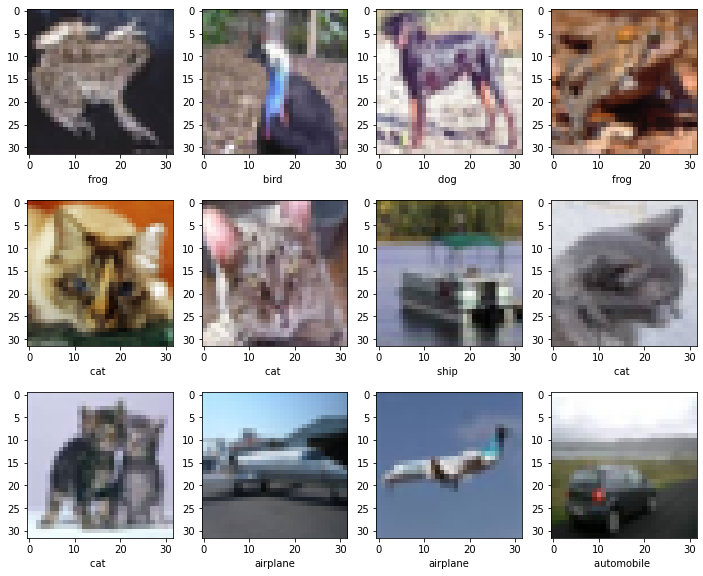

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [65]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

---



In [66]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [67]:
import keras
from keras import layers as L
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

In [68]:
X_train_shape = X_train.shape[1:]
X_train_shape

(32, 32, 3)

In [69]:
model = Sequential([
        L.Conv2D(filters=6, kernel_size=(5, 5), padding='same', activation='relu', input_shape=X_train_shape),
        L.Flatten(),
        L.Dense(32, activation='relu'),
        L.Dropout(0.5),
        L.Dense(10, activation='softmax')
])

In [70]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

1/1 [==============================] - 0s 125ms/step
Успех!


## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [71]:
y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

In [72]:
import datetime

In [73]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [74]:
callbacks = callbacks = [tensorboard_callback]

In [75]:
epochs = 12
batch_size = 32
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',              
              metrics=['accuracy'])
model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=[X_val, y_val],
              shuffle=True, 
              validation_split=0.2,
              callbacks=callbacks)

Epoch 1/12
1250/1250 [==============================] - 14s 11ms/step - loss: 2.0840 - accuracy: 0.2329 - val_loss: 1.8677 - val_accuracy: 0.3701
Epoch 2/12
1250/1250 [==============================] - 11s 9ms/step - loss: 1.8799 - accuracy: 0.3185 - val_loss: 1.6936 - val_accuracy: 0.4213
Epoch 3/12
1250/1250 [==============================] - 11s 9ms/step - loss: 1.7852 - accuracy: 0.3580 - val_loss: 1.5926 - val_accuracy: 0.4454
Epoch 4/12
1250/1250 [==============================] - 11s 8ms/step - loss: 1.7254 - accuracy: 0.3744 - val_loss: 1.5422 - val_accuracy: 0.4584
Epoch 5/12
1250/1250 [==============================] - 11s 9ms/step - loss: 1.6753 - accuracy: 0.3885 - val_loss: 1.5257 - val_accuracy: 0.4658
Epoch 6/12
1250/1250 [==============================] - 11s 9ms/step - loss: 1.6372 - accuracy: 0.4023 - val_loss: 1.4969 - val_accuracy: 0.4720
Epoch 7/12
1250/1250 [==============================] - 10s 8ms/step - loss: 1.6103 - accuracy: 0.4101 - val_loss: 1.4419 - val_a

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [76]:
from sklearn.metrics import accuracy_score
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
print(classes_x)
test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 1s 3ms/step
[3 8 8 ... 5 4 7]

 Test_acc = 0.5032
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [77]:
pocket_model = Sequential([
        L.Conv2D(filters=6, kernel_size=(5, 5), padding='same', activation='relu', input_shape=X_train_shape),
        L.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='relu'),
        L.MaxPool2D(pool_size=(2, 2), padding='valid'),
        L.Flatten(),
        L.Dense(100),
        L.Dropout(0.5),
        L.Activation('relu'),
        L.Dense(10, activation='softmax')
])

pocket_model.summary()


pocket_model.compile(loss='categorical_crossentropy',
              optimizer='sgd',              
              metrics=['accuracy'])

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 32, 32, 6)         456       
                                                                 
 conv2d_101 (Conv2D)         (None, 32, 32, 10)        550       
                                                                 
 max_pooling2d_91 (MaxPoolin  (None, 16, 16, 10)       0         
 g2D)                                                            
                                                                 
 flatten_47 (Flatten)        (None, 2560)              0         
                                                                 
 dense_138 (Dense)           (None, 100)               256100    
                                                                 
 dropout_105 (Dropout)       (None, 100)               0         
                                                     

In [78]:
pocket_model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=[X_val, y_val],
              shuffle=True, 
              validation_split=0.2,
              callbacks=callbacks)

Epoch 1/12
1250/1250 [==============================] - 22s 17ms/step - loss: 2.1086 - accuracy: 0.2280 - val_loss: 1.8660 - val_accuracy: 0.3564
Epoch 2/12
1250/1250 [==============================] - 24s 19ms/step - loss: 1.8455 - accuracy: 0.3420 - val_loss: 1.6586 - val_accuracy: 0.4083
Epoch 3/12
1250/1250 [==============================] - 24s 19ms/step - loss: 1.6938 - accuracy: 0.3956 - val_loss: 1.5421 - val_accuracy: 0.4556
Epoch 4/12
1250/1250 [==============================] - 23s 18ms/step - loss: 1.6099 - accuracy: 0.4216 - val_loss: 1.4930 - val_accuracy: 0.4650
Epoch 5/12
1250/1250 [==============================] - 23s 18ms/step - loss: 1.5549 - accuracy: 0.4415 - val_loss: 1.4551 - val_accuracy: 0.4795
Epoch 6/12
1250/1250 [==============================] - 24s 19ms/step - loss: 1.5100 - accuracy: 0.4587 - val_loss: 1.4321 - val_accuracy: 0.4879
Epoch 7/12
1250/1250 [==============================] - 25s 20ms/step - loss: 1.4756 - accuracy: 0.4723 - val_loss: 1.3825 -

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [79]:
pocket_predict_x=pocket_model.predict(X_test) 
pocket_classes_x=np.argmax(pocket_predict_x,axis=1)
print(pocket_classes_x)

pocket_test_acc = accuracy_score(y_test, pocket_classes_x)
print("\n Test_acc =", pocket_test_acc)
assert pocket_test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 2s 5ms/step
[3 1 8 ... 5 6 7]

 Test_acc = 0.5452
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций. 

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [80]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
            
    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
            
    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
        
    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, np.argmax(model.predict(X), axis=1))))

In [81]:
!rm -rf ./logs

In [82]:
from tensorflow.keras import optimizers as O

optimizers = {
    'Adam': O.Adam(),
    'SGD': O.SGD(),
    'RMSprop': O.RMSprop()
}

In [83]:
evaluator = Evaluator(model, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test, accuracy_score)

<ipython-input-80-1bc6c400137a>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):


  0%|          | 0/3 [00:00<?, ?it/s]

313/313 [==============================] - 1s 3ms/step
Final score of single_model_Adam is 0.4417
313/313 [==============================] - 1s 3ms/step
Final score of single_model_SGD is 0.5105
313/313 [==============================] - 1s 3ms/step
Final score of single_model_RMSprop is 0.377


In [84]:
evaluator = Evaluator(pocket_model, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test, accuracy_score)

<ipython-input-80-1bc6c400137a>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):


  0%|          | 0/3 [00:00<?, ?it/s]

313/313 [==============================] - 2s 4ms/step
Final score of single_model_Adam is 0.5722
313/313 [==============================] - 1s 4ms/step
Final score of single_model_SGD is 0.6082
313/313 [==============================] - 1s 4ms/step
Final score of single_model_RMSprop is 0.4638


In [85]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [86]:
%tensorboard --logdir logs


Reusing TensorBoard on port 6006 (pid 74803), started 1 day, 0:23:01 ago. (Use '!kill 74803' to kill it.)

Прокомментируйте полученные результаты.

Лучший результат у SGD

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [92]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)
        
    def add(self, layer):
        for name, model in self.items():
            model.add(layer)
            
    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})
        
    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage 
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# ...

In [93]:
model_1_4 = Sequential([
    L.Conv2D(filters=10,
            kernel_size=(3, 3),
            padding='same',
            activation='relu',
            input_shape=(32, 32, 3)),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.Conv2D(filters=10,
            kernel_size=(3, 3),
            padding='same',
            activation='relu'),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.BatchNormalization(),
    L.Flatten(),
    L.Dropout(0.3),       
    L.Dense(100, activation='relu'),
    L.Dropout(0.3),
    L.Dense(100, activation='relu'),
    L.BatchNormalization(),
    L.Dense(10, activation='softmax')
    ])

In [94]:
model_1_4.compile(
    loss='categorical_crossentropy',
    optimizer=O.SGD(),
    metrics=["accuracy"])

In [95]:
callbacks_1_4 =[
    keras.callbacks.EarlyStopping(
    monitor ="val_accuracy",
    patience=2,
    verbose=2,
    mode="max",
    restore_best_weights=True
   )
    ]

In [96]:
model_1_4.fit(X_train, y_train, batch_size=64, epochs=7, verbose=1, callbacks=callbacks_1_4, validation_data=(X_val, y_val))

Epoch 1/7
625/625 [==============================] - 18s 21ms/step - loss: 2.0781 - accuracy: 0.2654 - val_loss: 1.7227 - val_accuracy: 0.3845
Epoch 2/7
625/625 [==============================] - 14s 22ms/step - loss: 1.7236 - accuracy: 0.3688 - val_loss: 1.5509 - val_accuracy: 0.4373
Epoch 3/7
625/625 [==============================] - 18s 29ms/step - loss: 1.6215 - accuracy: 0.4107 - val_loss: 1.4686 - val_accuracy: 0.4708
Epoch 4/7
625/625 [==============================] - 10s 17ms/step - loss: 1.5601 - accuracy: 0.4311 - val_loss: 1.4349 - val_accuracy: 0.4856
Epoch 5/7
625/625 [==============================] - 11s 17ms/step - loss: 1.5230 - accuracy: 0.4476 - val_loss: 1.7158 - val_accuracy: 0.4102
Epoch 6/7
625/625 [==============================] - 11s 17ms/step - loss: 1.4927 - accuracy: 0.4604 - val_loss: 1.3826 - val_accuracy: 0.4990
Epoch 7/7
625/625 [==============================] - 11s 17ms/step - loss: 1.4570 - accuracy: 0.4740 - val_loss: 1.4729 - val_accuracy: 0.4691

In [31]:
predict_x = model_1_4.predict(X_test)
classes_x = np.argmax(predict_x, axis=1)
test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)

313/313 [==============================] - 1s 4ms/step

 Test_acc = 0.5013


In [97]:
model_2_4 = Sequential([
    L.Conv2D(filters=10,
            kernel_size=(3, 3),
            padding='same',
            activation='relu',
            input_shape=(32, 32, 3)),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.BatchNormalization(),
    L.Conv2D(filters=10,
            kernel_size=(3, 3),
            padding='same',
            activation='relu'),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.BatchNormalization(),
    L.Flatten(),
    L.Dropout(0.3),       
    L.Dense(100, activation='relu'),
    L.Dropout(0.3),
    L.Dense(100, activation='relu'),
    L.BatchNormalization(),
    L.Dense(10, activation='softmax')])

In [98]:
model_2_4.compile(
    loss='categorical_crossentropy',
    optimizer=O.SGD(),
    metrics=["accuracy"])

In [99]:
model_2_4.fit(X_train, y_train, batch_size=32, epochs=7, verbose=1, callbacks=callbacks_1_4, validation_data=(X_val, y_val))

Epoch 1/7
1250/1250 [==============================] - 16s 12ms/step - loss: 1.9214 - accuracy: 0.3134 - val_loss: 1.5881 - val_accuracy: 0.4219
Epoch 2/7
1250/1250 [==============================] - 16s 13ms/step - loss: 1.6297 - accuracy: 0.4089 - val_loss: 1.5305 - val_accuracy: 0.4429
Epoch 3/7
1250/1250 [==============================] - 15s 12ms/step - loss: 1.5339 - accuracy: 0.4430 - val_loss: 1.3888 - val_accuracy: 0.4935
Epoch 4/7
1250/1250 [==============================] - 14s 11ms/step - loss: 1.4739 - accuracy: 0.4646 - val_loss: 1.3676 - val_accuracy: 0.5074
Epoch 5/7
1250/1250 [==============================] - 14s 11ms/step - loss: 1.4350 - accuracy: 0.4791 - val_loss: 1.2699 - val_accuracy: 0.5418
Epoch 6/7
1250/1250 [==============================] - 14s 11ms/step - loss: 1.3955 - accuracy: 0.4969 - val_loss: 1.5072 - val_accuracy: 0.4709
Epoch 7/7
1250/1250 [==============================] - 14s 11ms/step - loss: 1.3696 - accuracy: 0.5114 - val_loss: 1.2621 - val_ac

In [100]:
predict_x = model_2_4.predict(X_test)
classes_x = np.argmax(predict_x, axis=1)
test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)

313/313 [==============================] - 2s 4ms/step

 Test_acc = 0.5514


Прокомментируйте полученные результаты.

Использование BatchNormalization позволило улучшить точность модели

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

In [101]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [102]:
callbacks_1_5 = [
    MyThresholdCallback(threshold=0.55)]

In [103]:
def model_1_5(n):
    model_1_5 = Sequential([
      L.Conv2D(filters=10,
              kernel_size=(3, 3),
              padding='same',
              activation='relu',
              input_shape=(32, 32, 3)),
      L.BatchNormalization(), 
      L.MaxPool2D(pool_size=(2, 2), padding='valid'),
      L.BatchNormalization(),
      L.Conv2D(filters=10,
                     kernel_size=(3, 3),
                     padding='same',
                     activation='relu'),
      L.MaxPool2D(pool_size=(2, 2), padding='valid'),
      L.BatchNormalization(),
      L.Flatten(),
      L.Dropout(0.3),       
      L.Dense(100, activation='relu'),
      L.Dropout(0.3),
      L.Dense(100, activation='relu'),
      L.BatchNormalization(),
      L.Dense(10, activation='softmax')])
    model_1_5.compile(
       loss='categorical_crossentropy',
       optimizer=O.SGD(),
       metrics=["accuracy"])
    history = model_1_5.fit(X_train, y_train, batch_size= n, epochs=100, verbose=0, callbacks=callbacks_1_5, validation_data=(X_val, y_val))
    return history.history

In [104]:
from tqdm import tqdm_notebook
from tqdm.notebook import tqdm

In [105]:
for n in tqdm(range(5, 100, 10)):
    print('----------------------------')
    print('batch_size =', n)
    history_dict_1_5 = model_1_5(n)
    val_acc = np.around(np.max(history_dict_1_5['val_accuracy']), decimals = 2)
    print('val_accuracy=', val_acc)  

  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------
batch_size = 5
val_accuracy= 0.59
----------------------------
batch_size = 15
val_accuracy= 0.56
----------------------------
batch_size = 25
val_accuracy= 0.58
----------------------------
batch_size = 35
val_accuracy= 0.55
----------------------------
batch_size = 45
val_accuracy= 0.58
----------------------------
batch_size = 55
val_accuracy= 0.58
----------------------------
batch_size = 65
val_accuracy= 0.55
----------------------------
batch_size = 75
val_accuracy= 0.55
----------------------------
batch_size = 85
val_accuracy= 0.55
----------------------------
batch_size = 95
val_accuracy= 0.57


Размер batch - 5 показал лучшую точность, но дольше обучается


**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

In [106]:
def model_1_6(X_train, y_train, X_val, y_val, optimizer):
    model = Sequential([
      L.Conv2D(filters=10,
              kernel_size=(3, 3),
              padding='same',
              activation='relu',
              input_shape=(32, 32, 3)),
      L.MaxPool2D(pool_size=(2, 2), padding='valid'),
      L.BatchNormalization(),
      L.Conv2D(filters=10,
              kernel_size=(3, 3),
              padding='same',
              activation='relu'),
      L.MaxPool2D(pool_size=(2, 2), padding='valid'),
      L.BatchNormalization(),
      L.Dropout(0.3),
      L.Flatten(),
      L.Dense(100, activation='relu'),
      L.BatchNormalization(),
      L.Dropout(0.3),
      L.Dense(100, activation='relu'),
      L.BatchNormalization(),
      L.Dense(10, activation='softmax')])
    model.compile(
       loss='categorical_crossentropy',
       optimizer=optimizer,
       metrics=["accuracy"],)
    stopper = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        patience=2,
        verbose=0,
        restore_best_weights=True
        )
    history = model.fit(X_train, y_train, batch_size= 55, epochs=10, verbose=0, 
                        callbacks=stopper, validation_data=(X_val, y_val))
    return history.history

In [107]:
def modelfit(optimizer):    
    train_scores = []
    test_scores = []
    for train_sizes in tqdm(np.linspace(0.1, 0.99, 10)):
        print('_____________________________________________________________________________')
        print("train_sizes=", train_sizes)
        X1, X2, y1, y2 = train_test_split(X_train, y_train, train_size = train_sizes)        
        history_dict = model_1_6(X1, y1, X2, y2, optimizer)
        acc = np.around(np.max(history_dict['accuracy']), decimals = 2)
        val_acc = np.around(np.max(history_dict['val_accuracy']), decimals = 2)
        print('Training accuracy=', acc, ';', 'Validation accuracy=', val_acc)
        print('_____________________________________________________________________________')
        train_scores.append(acc)
        test_scores.append(val_acc)    
    return train_scores, test_scores 

In [108]:
optimizers = {'sgd': O.SGD(), 'rms': O.RMSprop(), 'adam': O.Adam()}

sgd


  0%|          | 0/10 [00:00<?, ?it/s]

_____________________________________________________________________________
train_sizes= 0.1
Training accuracy= 0.39 ; Validation accuracy= 0.4
_____________________________________________________________________________
_____________________________________________________________________________
train_sizes= 0.1988888888888889
Training accuracy= 0.43 ; Validation accuracy= 0.44
_____________________________________________________________________________
_____________________________________________________________________________
train_sizes= 0.2977777777777778
Training accuracy= 0.42 ; Validation accuracy= 0.45
_____________________________________________________________________________
_____________________________________________________________________________
train_sizes= 0.3966666666666666
Training accuracy= 0.38 ; Validation accuracy= 0.37
_____________________________________________________________________________
________________________________________________________

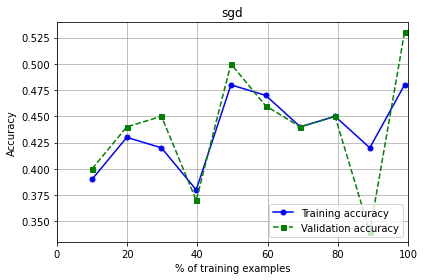

rms


  0%|          | 0/10 [00:00<?, ?it/s]

_____________________________________________________________________________
train_sizes= 0.1
Training accuracy= 0.56 ; Validation accuracy= 0.47
_____________________________________________________________________________
_____________________________________________________________________________
train_sizes= 0.1988888888888889
Training accuracy= 0.52 ; Validation accuracy= 0.44
_____________________________________________________________________________
_____________________________________________________________________________
train_sizes= 0.2977777777777778
Training accuracy= 0.52 ; Validation accuracy= 0.5
_____________________________________________________________________________
_____________________________________________________________________________
train_sizes= 0.3966666666666666
Training accuracy= 0.56 ; Validation accuracy= 0.53
_____________________________________________________________________________
________________________________________________________

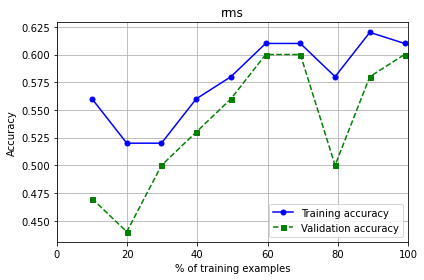

adam


  0%|          | 0/10 [00:00<?, ?it/s]

_____________________________________________________________________________
train_sizes= 0.1
Training accuracy= 0.57 ; Validation accuracy= 0.47
_____________________________________________________________________________
_____________________________________________________________________________
train_sizes= 0.1988888888888889
Training accuracy= 0.6 ; Validation accuracy= 0.55
_____________________________________________________________________________
_____________________________________________________________________________
train_sizes= 0.2977777777777778
Training accuracy= 0.59 ; Validation accuracy= 0.57
_____________________________________________________________________________
_____________________________________________________________________________
train_sizes= 0.3966666666666666
Training accuracy= 0.61 ; Validation accuracy= 0.6
_____________________________________________________________________________
_________________________________________________________

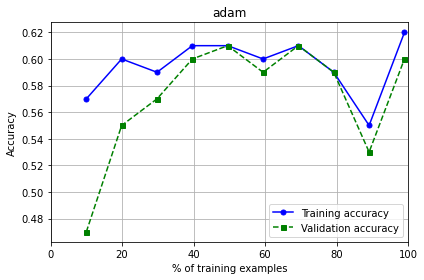

In [109]:
for optimizer_name, optimizer in optimizers.items():
    print(optimizer_name)
    train_scores, test_scores = modelfit(optimizer)   
    train_sizes = [i for i in np.linspace(0.1, 0.99, 10)]
    
    plt.title(optimizer_name)
    plt.plot(np.array(train_sizes)*100, train_scores,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

    plt.plot(np.array(train_sizes)*100, test_scores,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

    plt.grid()
    plt.xlabel('% of training examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.xlim([0, 100])
    plt.tight_layout()
    plt.show()

Наиболее приближена к проверочной модели - Adam, хотя наилучшая точность у RMS на 99% образцов